In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 5)

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import datetime
from dateutil.relativedelta import relativedelta
from arch import arch_model

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

p = print

C:\Users\blacat\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Используем полезные функции, любезно предоставленные лектором

In [2]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    rolmean = pd.rolling_mean(y, window=12)
    rolstd = pd.rolling_std(y, window=12)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        rolmean.plot(ax=ts_ax, color='red')
        rolstd.plot(ax=ts_ax, color='black')
        ts_ax.set_title('Original(blue), Rolling Mean(red) & Standard Deviation(black)')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')

        plt.tight_layout()
    return

In [3]:
#######################
# разложение на компоненты
#########################
def seasonal_decompose_plot(y,  freq=None):
    if not isinstance(y, pd.Series): # не является рядом?
        y = pd.Series(y) # преобразовать в ряд

    decomposition = seasonal_decompose(y, freq=freq)
    # fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    return

In [4]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [50]:
# Выбор модели SARIMA согласно AIC
def sarima_best_order(timeseries, s):
    max_lag = 30
    best_aic = np.inf
    best_order = None
    best_order_s = None
    best_mdl = None
    pq_rng = range(5)  # [0,1,2,3,4]
    d_rng = range(2)  # [0,1]
    s_rng = s
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                for si in pq_rng:
                    for sd in d_rng:
                        for sj in pq_rng:
                            for s in s_rng:
                                try:
                                    tmp_mdl = smt.SARIMAX(timeseries, trend='n', order=(i,d,j), seasonal_order=(si,sd,sj,s))
                                    results = tmp_mdl.fit()
                                    tmp_aic = results.aic
                                    #tmp_mdl = smt.ARIMA(timeseries, order=(i, d, j)).fit(maxlag=max_lag, method='mle', trend='nc')
                                    #tmp_aic = tmp_mdl.aic
                                    if tmp_aic < best_aic:
                                        best_aic = tmp_aic
                                        best_order = (i, d, j)
                                        best_order_s = (si, sd, sj, s)
                                        best_mdl = tmp_mdl
                                except: continue
    p('aic: {:6.5f} | order: {} | order_s: {}'.format(best_aic, best_order, best_order_s))
    return best_mdl

In [69]:
def mape_f(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true.shape))

In [80]:
# Выбор модели ARIMA согласно MAPE
def sarima_best_order_mape(timeseries, s):
    max_lag = 30
    best_mape = np.inf
    best_order = None
    best_order_s = None
    best_mdl = None
    pq_rng = range(5)  # [0,1,2,3,4]
    d_rng = range(3)  # [0,1]
    s_rng = s
    for i in pq_rng:        
        for d in d_rng:
            for j in pq_rng:
                for si in pq_rng:
                    for sd in d_rng:
                        for sj in pq_rng:
                            for s in s_rng:
                                try:
                                    tmp_mdl = smt.SARIMAX(timeseries, trend='n', order=(i,d,j), seasonal_order=(si,sd,sj,s))
                                    mdl_res = tmp_mdl.fit()
                                    mdl_pred = mdl_res.predict()
                                    delta = timeseries.shape[0]-mdl_pred.shape[0]
                                    
                                    if delta >0 :
                                        print(i, delta)
                                        tmp_mape = mape_f(timeseries[:-delta], mdl_pred)
                                    else:
                                        tmp_mape = mape_f(timeseries, mdl_pred)
                                        
                                    
                                    if tmp_mape < best_mape:
                                        best_mape = tmp_mape
                                        best_order = (i, d, j)
                                        best_order_s = (si, sd, sj, s)
                                        best_mdl = tmp_mdl
                                except: continue
    p('mape: {:6.5f} | order: {} | order_s: {}'.format(best_mape, best_order, best_order_s))
    return best_mdl

In [8]:
# зафиксируем выборку
np.random.seed(1)

# Исследуем реальные данные

In [9]:
# Загрузим данные
cols = ['num_tr']
df = pd.read_csv('Sales.csv', index_col=0, names=cols , skiprows=1)
df.index.name='date'
df.reset_index(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
date      144 non-null object
num_tr    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [11]:
df.describe()

,num_tr
count,144.000000
mean,389.694444
std,171.500016
min,138.000000
25%,248.500000
50%,369.000000
75%,509.250000
max,871.000000


In [12]:
df.tail()

,date,num_tr
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519
143,Dec-14,605


In [13]:
#  Укажем формат времени
start = datetime.datetime.strptime("2003-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,144)]
df['index'] = date_list
df.set_index(['index'], inplace=True)
df.index.name=None

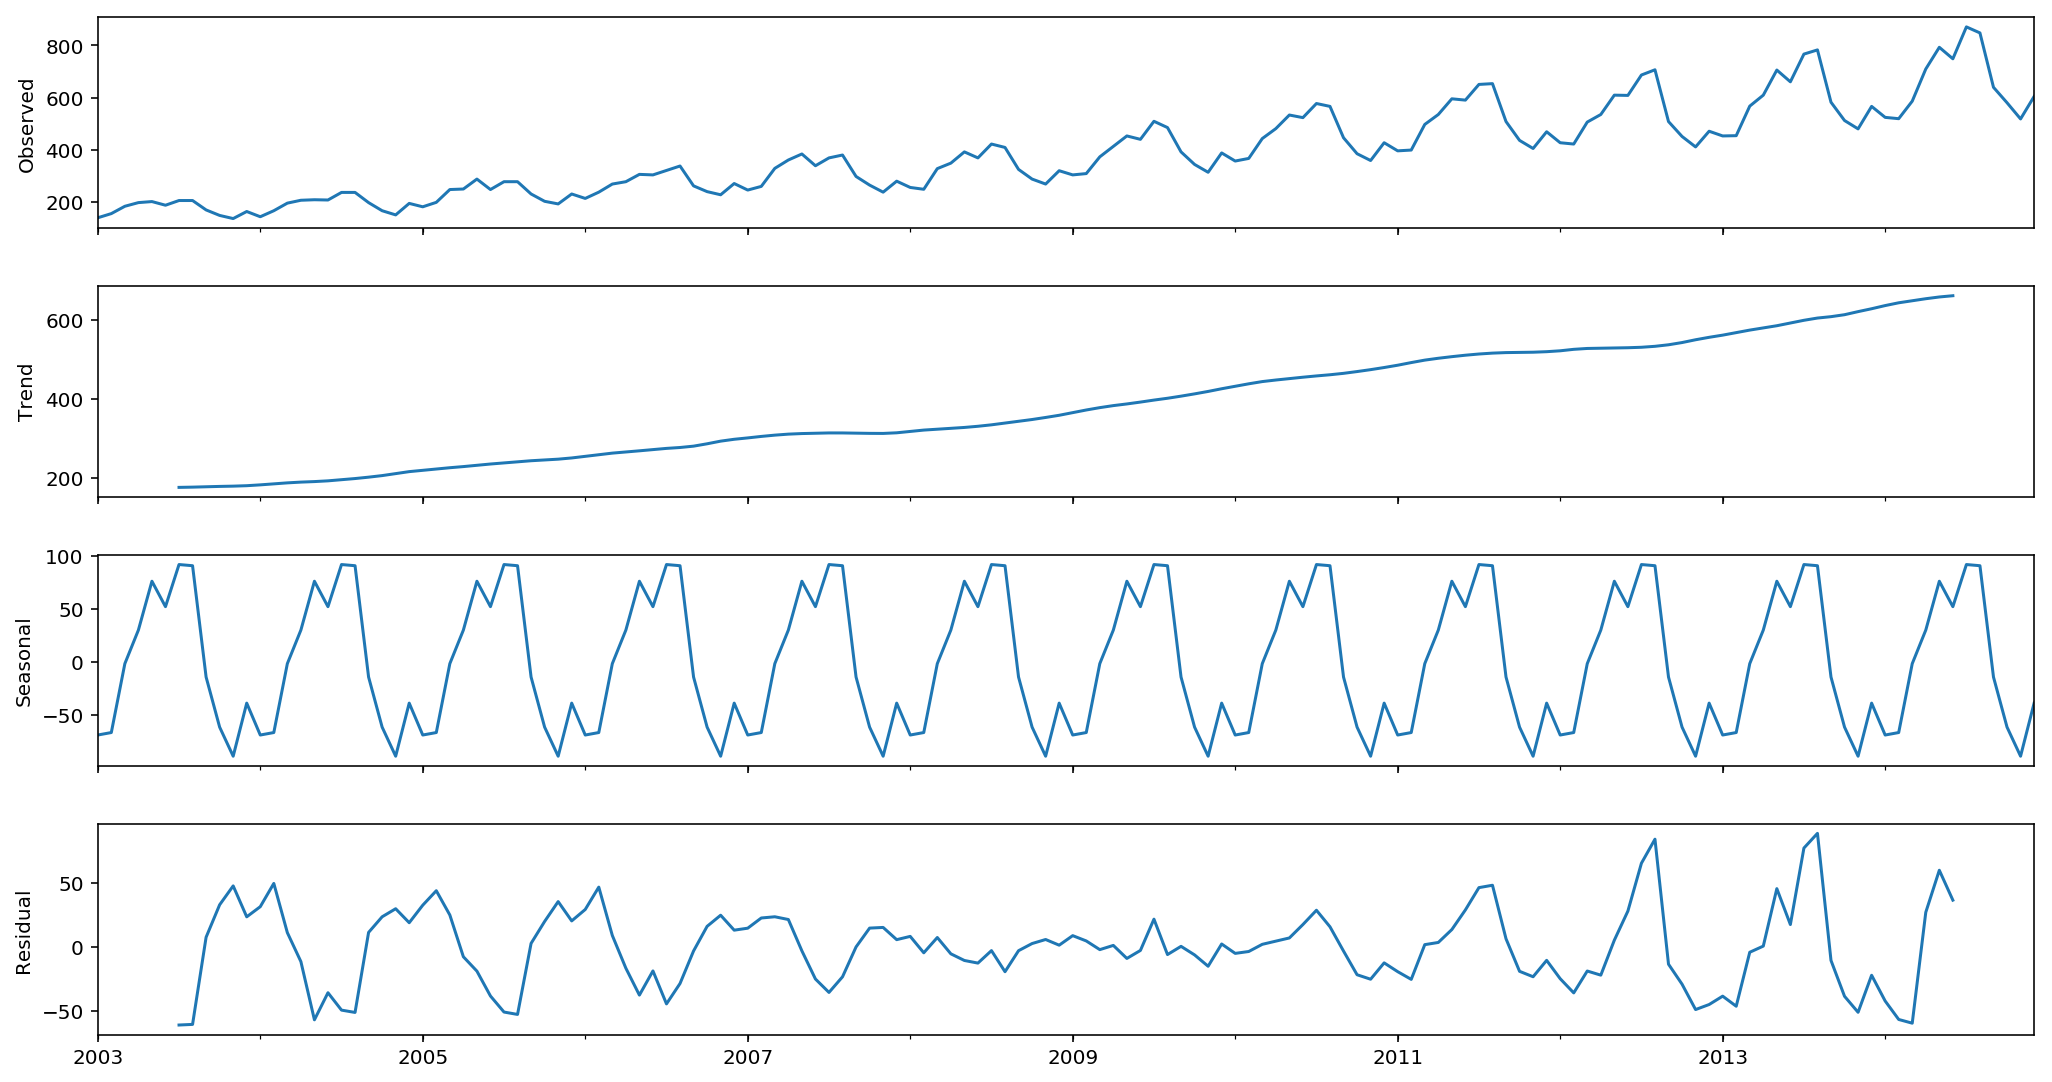

In [96]:
seasonal_decompose_plot(df.num_tr,  freq=12)

п. 2 Постройте график ряда, сделайте предположение о тренде, сезонности, стационарности

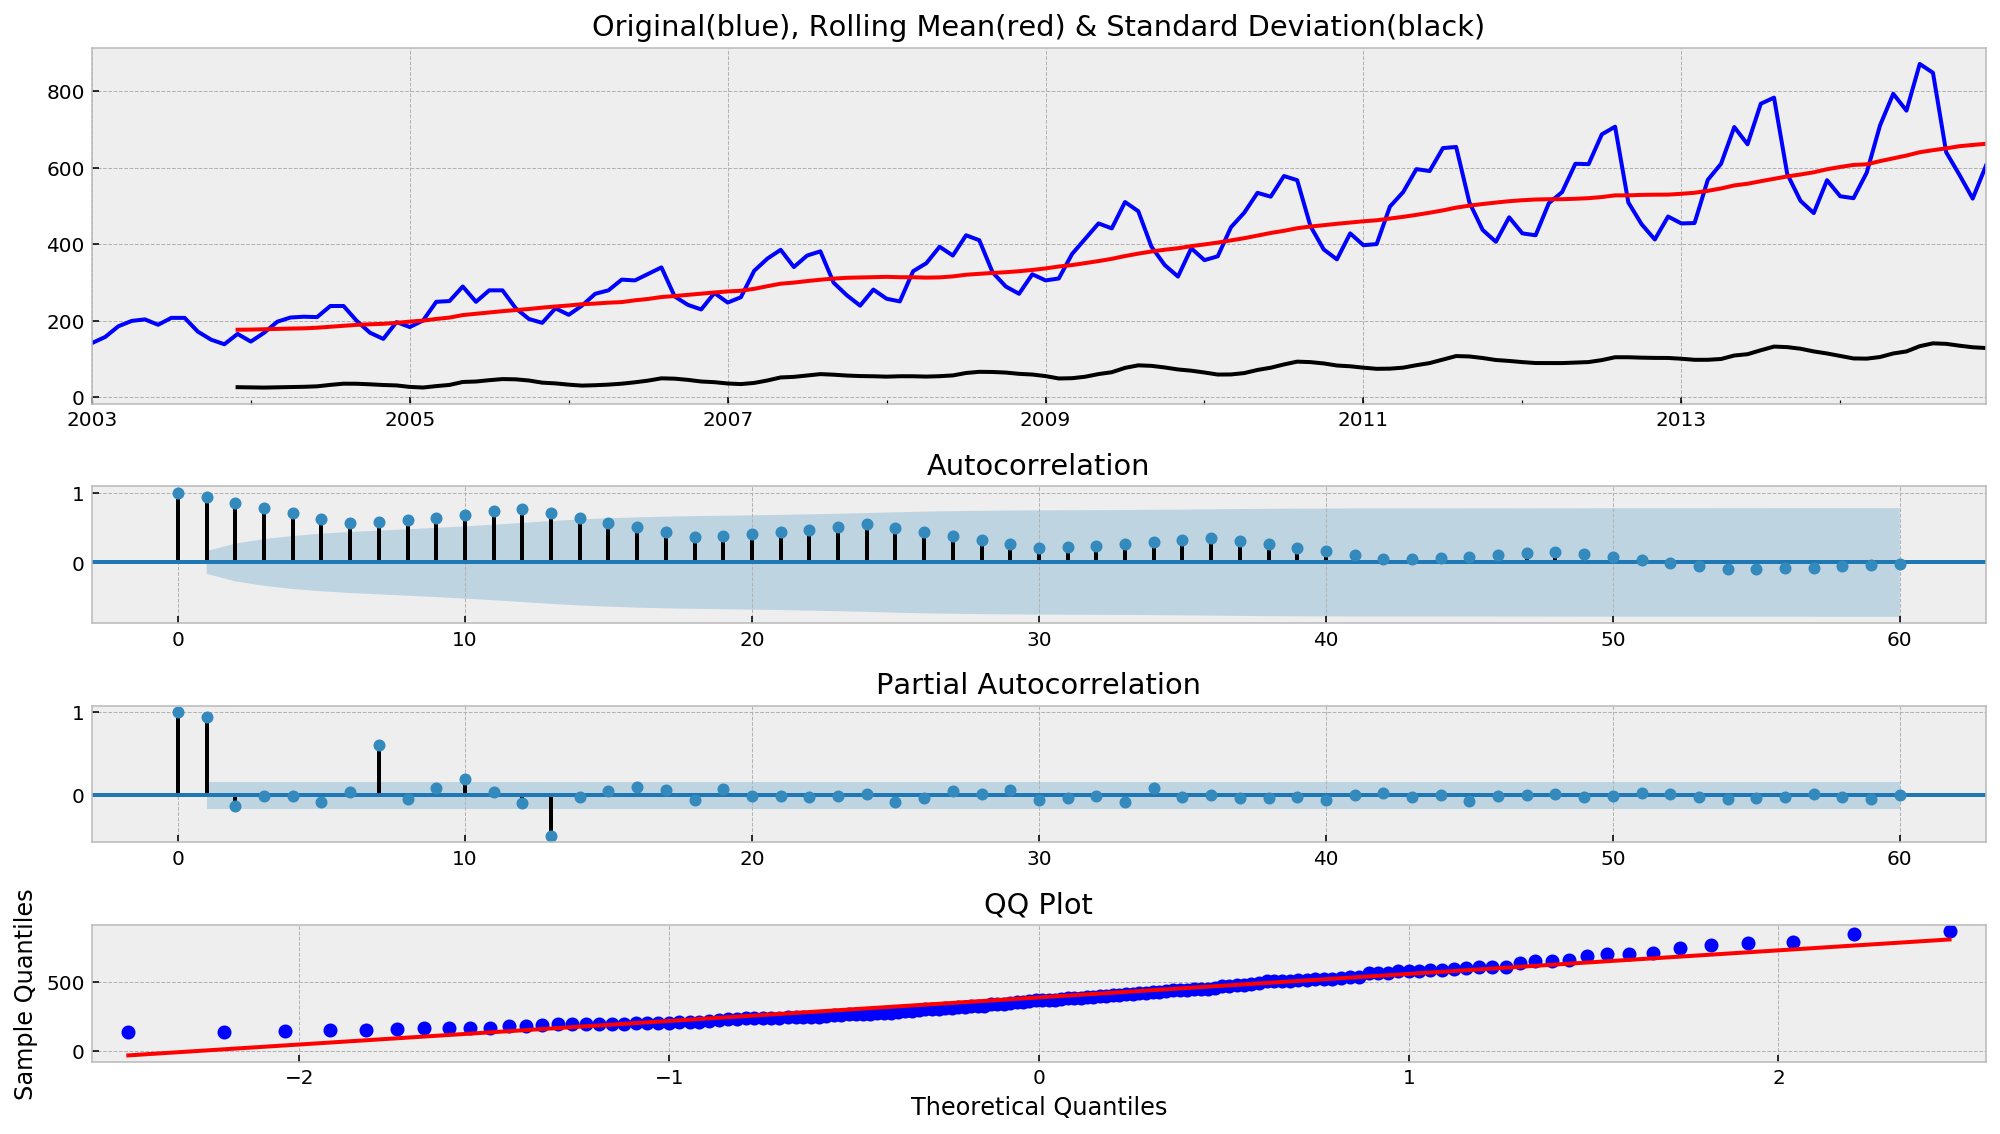

In [15]:
tsplot(df.num_tr, lags=60)

Из анализа изображений: временной ряд с трендом, 
нестационарный - график автокорреляционной функции медленно угасает;
частная автокорреляция показывает, что есть сезонность в 6-ом и 12-ом месяцах;
QQ график показывает, что временной ряд далек от стационарности.

In [16]:
test_stationarity(df.num_tr)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


Гипотеза о стационарности после теста Дики-Фуллера отвергается, нестационарный временной ряд.

п. 3 Разделите контрольную (последние 5 мес.) и обучающую (остальное) выборки

In [59]:
train = df[df.index < '2014-08-01']
test = df[df.index >= '2014-08-01']

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 2003-01-01 to 2014-07-01
Data columns (total 6 columns):
date                         139 non-null object
num_tr                       139 non-null int64
first_difference             138 non-null float64
seasonal_first_difference    126 non-null float64
f_aic                        0 non-null float64
f_aic_12                     0 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.6+ KB


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2014-08-01 to 2014-12-01
Data columns (total 2 columns):
date      5 non-null object
num_tr    5 non-null int64
dtypes: int64(1), object(1)
memory usage: 120.0+ bytes


In [20]:
test.head()

,date,num_tr
2014-08-01,Aug-14,848
2014-09-01,Sep-14,640
2014-10-01,Oct-14,581
2014-11-01,Nov-14,519
2014-12-01,Dec-14,605


п. 4 Приведите исходный ряд к стационарному

Results of Dickey-Fuller Test:
Test Statistic                  -1.436190
p-value                          0.564809
#Lags Used                      13.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
Critical Value (10%)            -2.579257
dtype: float64


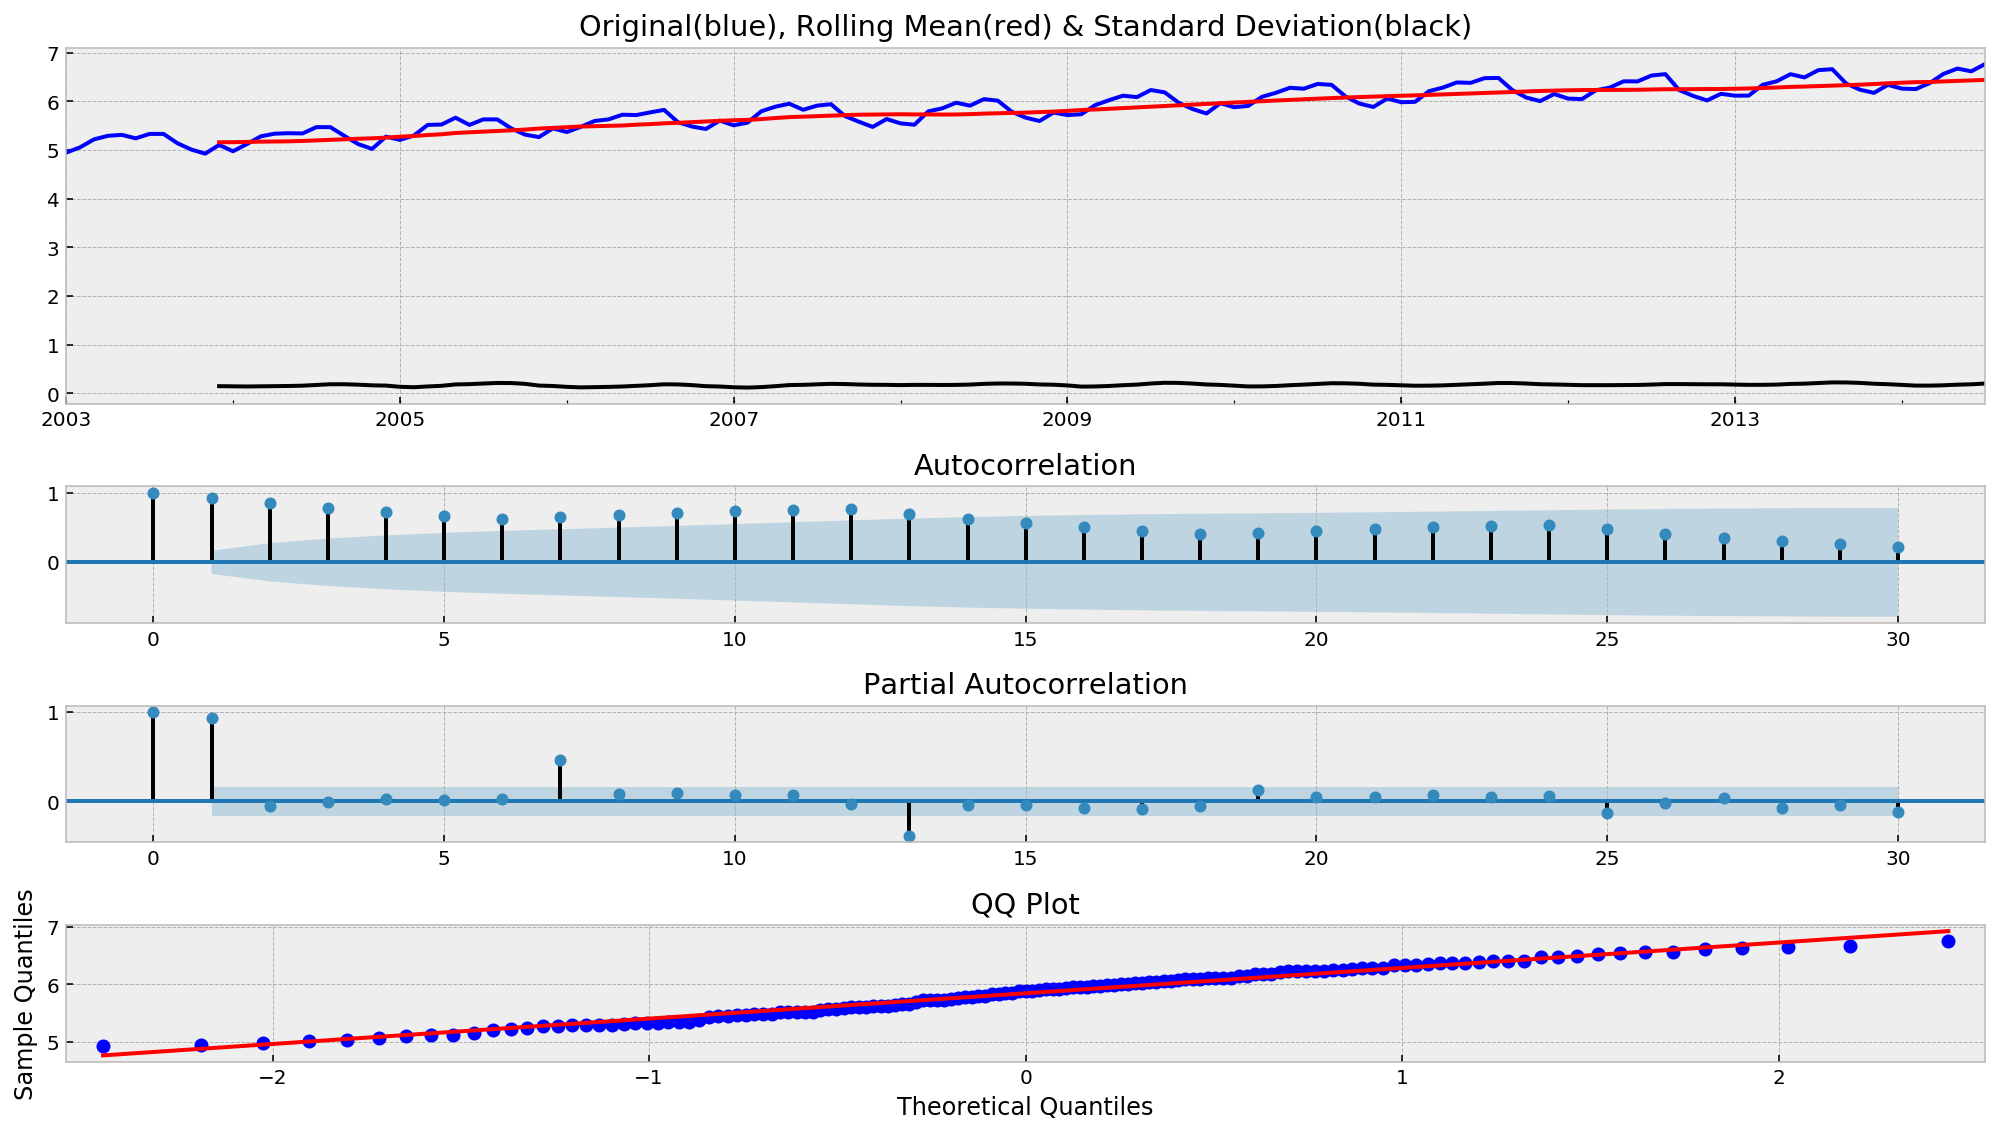

In [21]:
# логарифмируем, на всякий случаем проверяем ДФ, отрисовываем графики, чтобы понять, как изменился временной ряд
train.num_tr_log = train.num_tr.apply(lambda x: np.log(x))
df.num_tr_log = df.num_tr.apply(lambda x: np.log(x))
test_stationarity(train.num_tr_log.dropna(inplace=False))
tsplot(train.num_tr_log, lags=30)

Нестационарный, продолжаем работу с данными



Results of Dickey-Fuller Test:
Test Statistic                  -2.293495
p-value                          0.174074
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


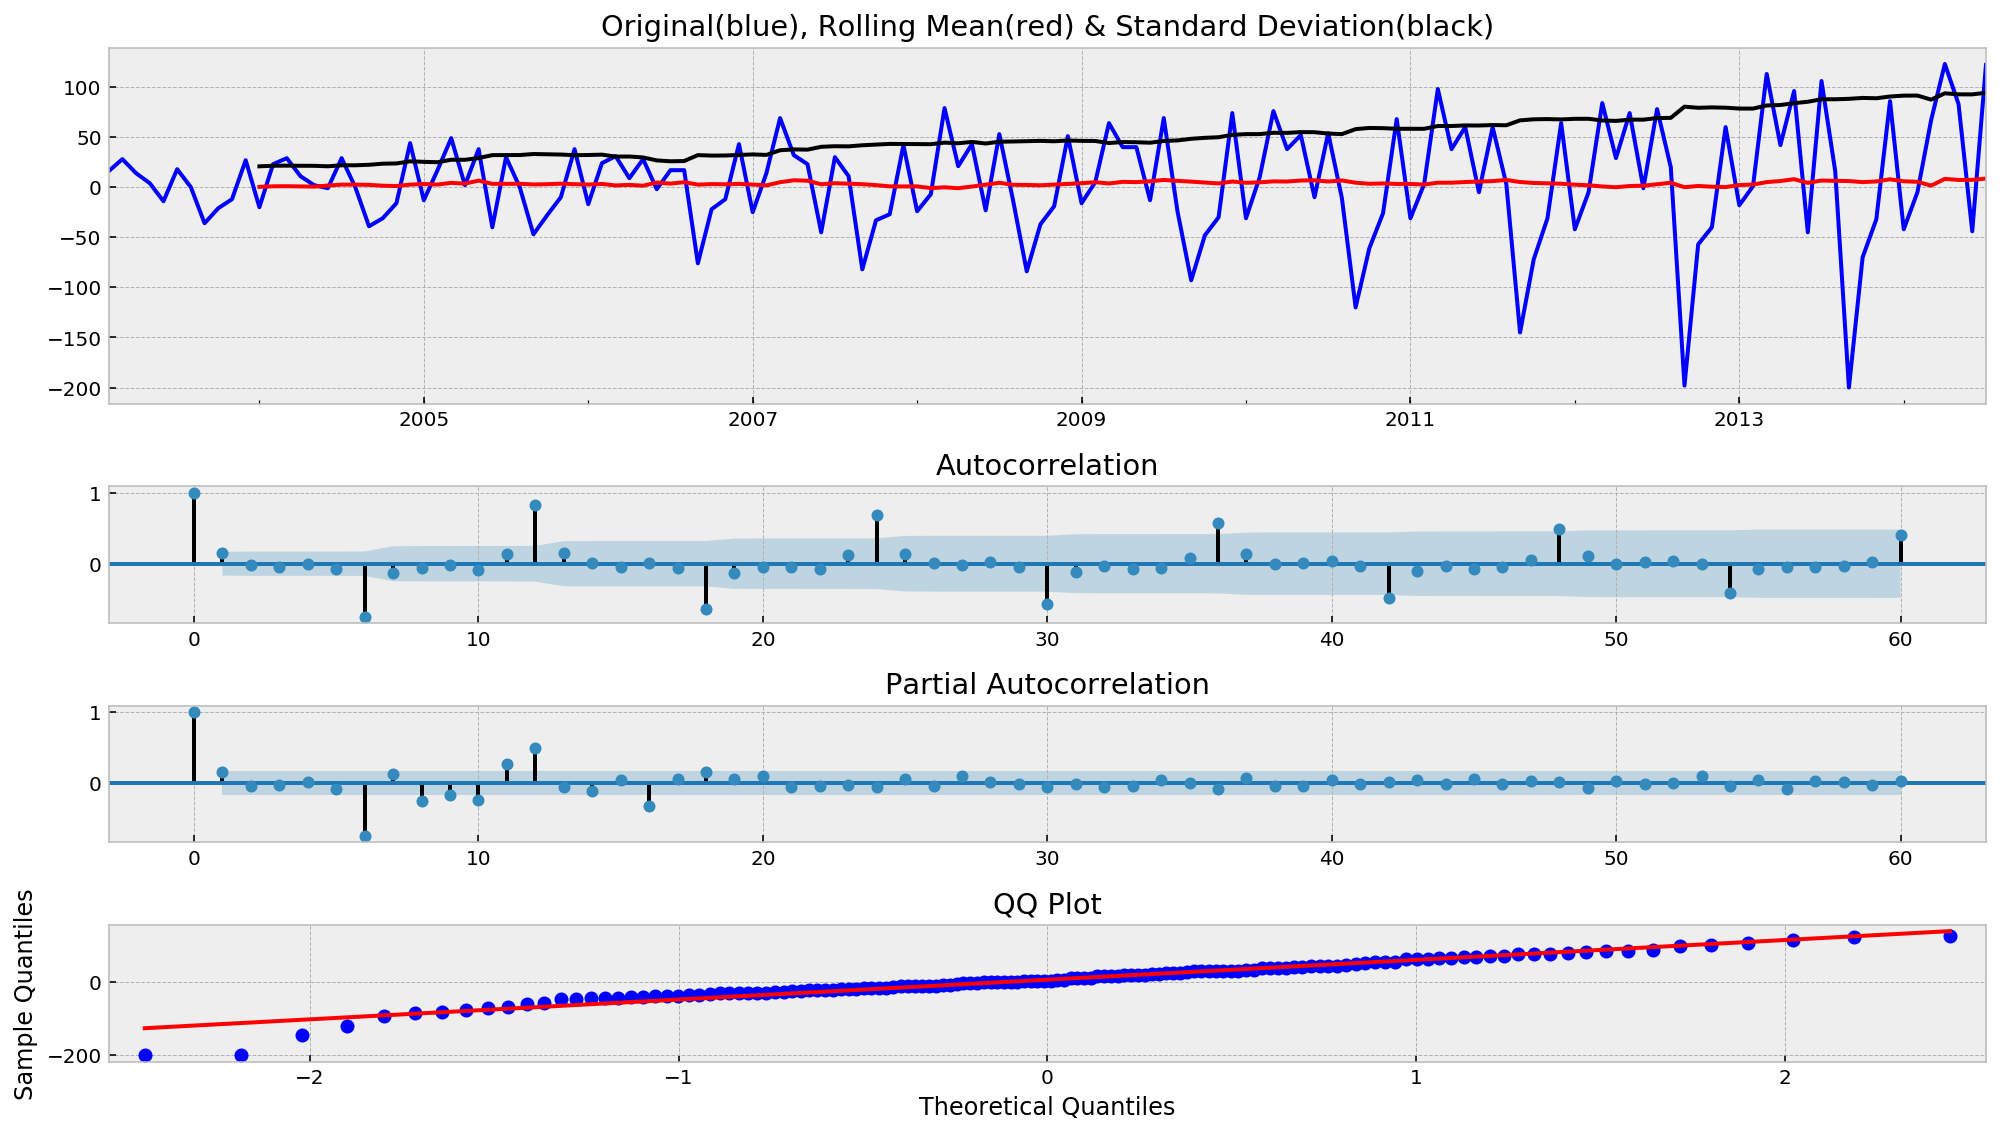

In [22]:
#первые разности 
train['first_difference'] = train.num_tr - train.num_tr.shift(1)
df['first_difference'] = df.num_tr - df.num_tr.shift(1)
test_stationarity(train.first_difference.dropna(inplace=False))
tsplot(train.first_difference[1:], lags = 60)

Нестационарный, продолжаем работать с данными

Results of Dickey-Fuller Test:
Test Statistic                  -2.689739
p-value                          0.075831
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


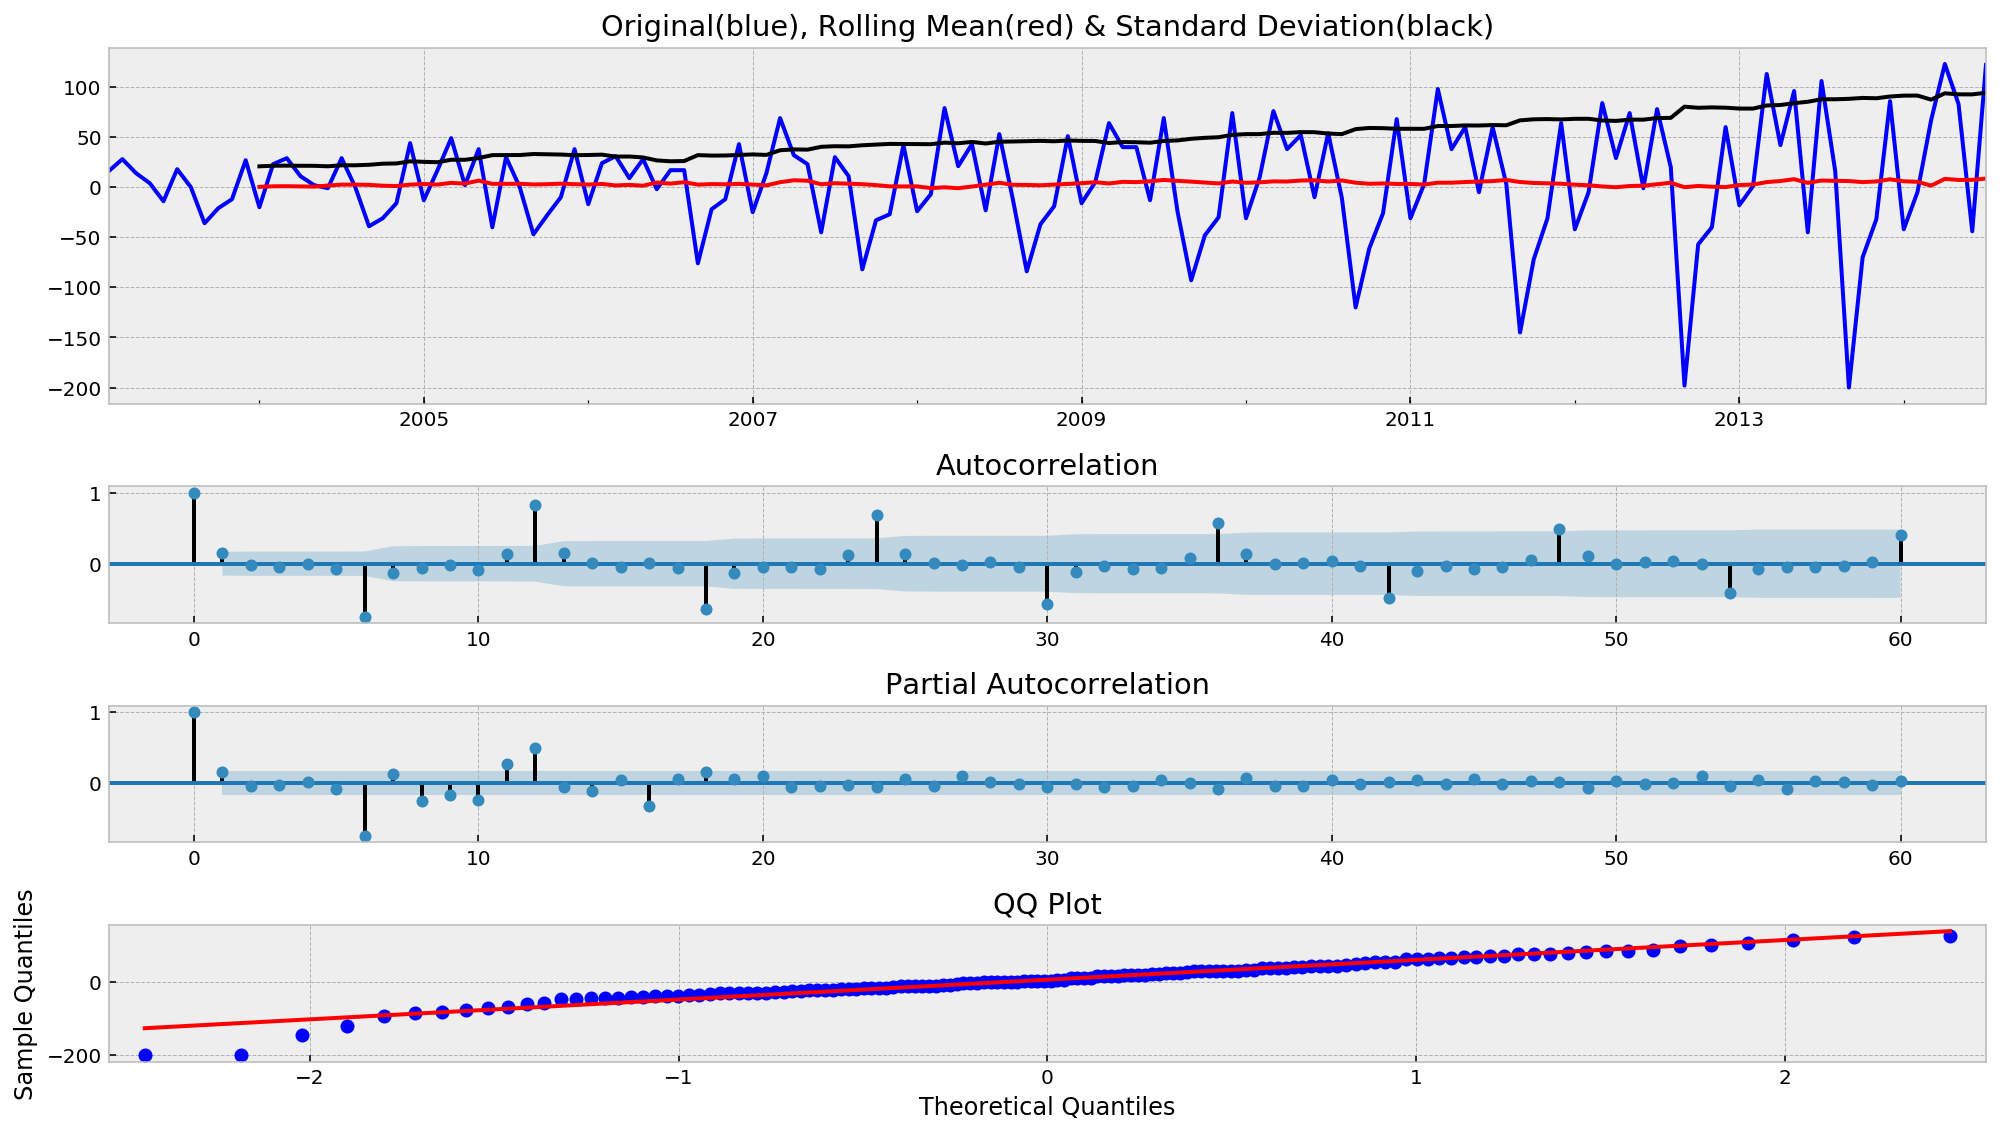

In [23]:
# логарифм первых разностей 
train['log_first_difference'] = train.num_tr_log - train.num_tr_log.shift(1)
test_stationarity(train.log_first_difference.dropna(inplace=False))
tsplot(train.first_difference[1:], lags = 60)

Нестационарный, продолжаем преобразовывать временной ряд

Results of Dickey-Fuller Test:
Test Statistic                  -2.927774
p-value                          0.042212
#Lags Used                       1.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
Critical Value (10%)            -2.579257
dtype: float64


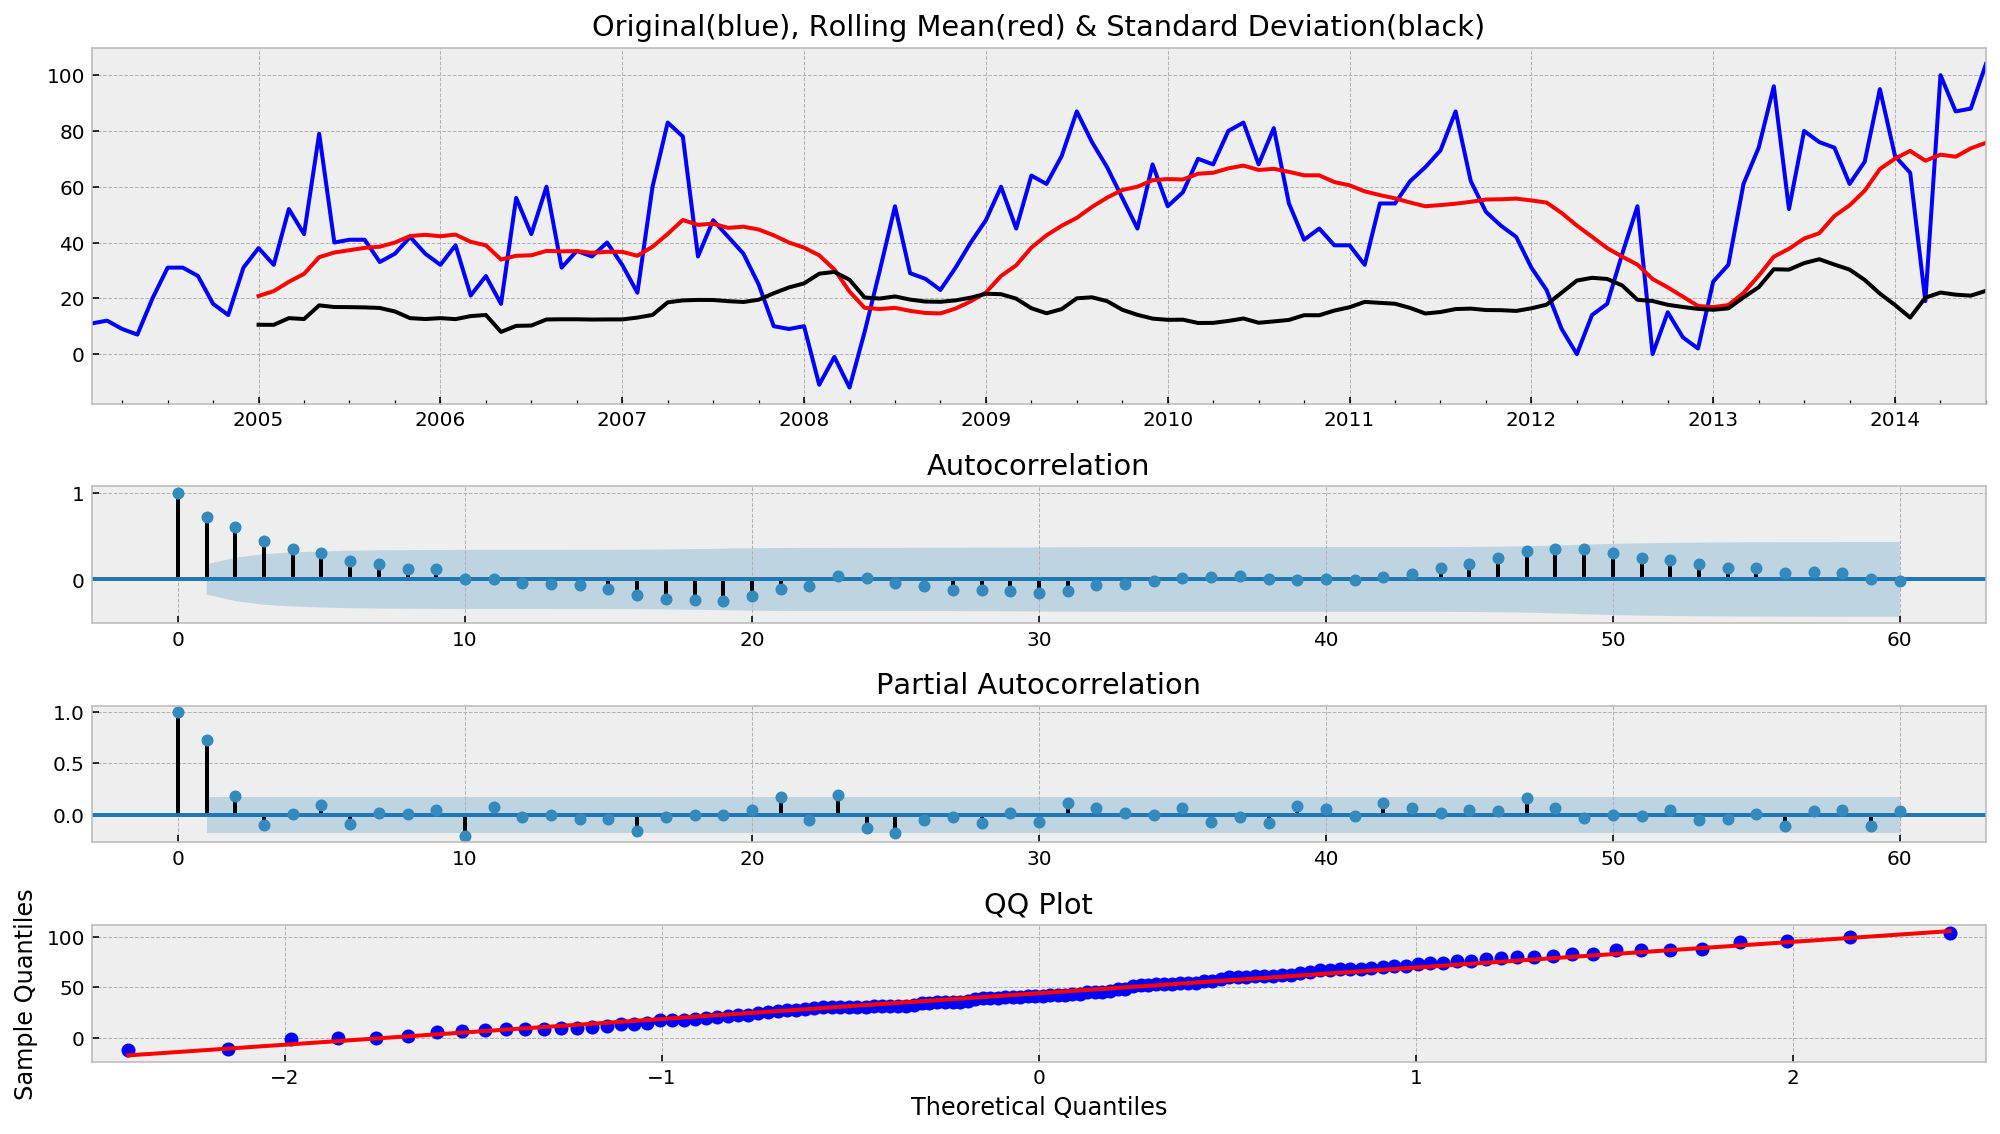

In [24]:
# seasonal component 12 month, ярко выражена на графике частой автокорреляции, 
# есть компоента на 6-ти месяцах, ее пока не принимаем во внимание
train['seasonal_difference'] = train.num_tr -  train.num_tr.shift(12)
test_stationarity(train.seasonal_difference.dropna(inplace=False))
tsplot(train.seasonal_difference[13:], lags = 60)

По тесту ДФ ряд можно считать стационарным (p-value < 0.05), по посмотрим, можно ли как-то улучшить результат, улучшить поведение
автокорреляционной фукции и частной автокорреляции.

Results of Dickey-Fuller Test:
Test Statistic                  -2.680078
p-value                          0.077549
#Lags Used                      12.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


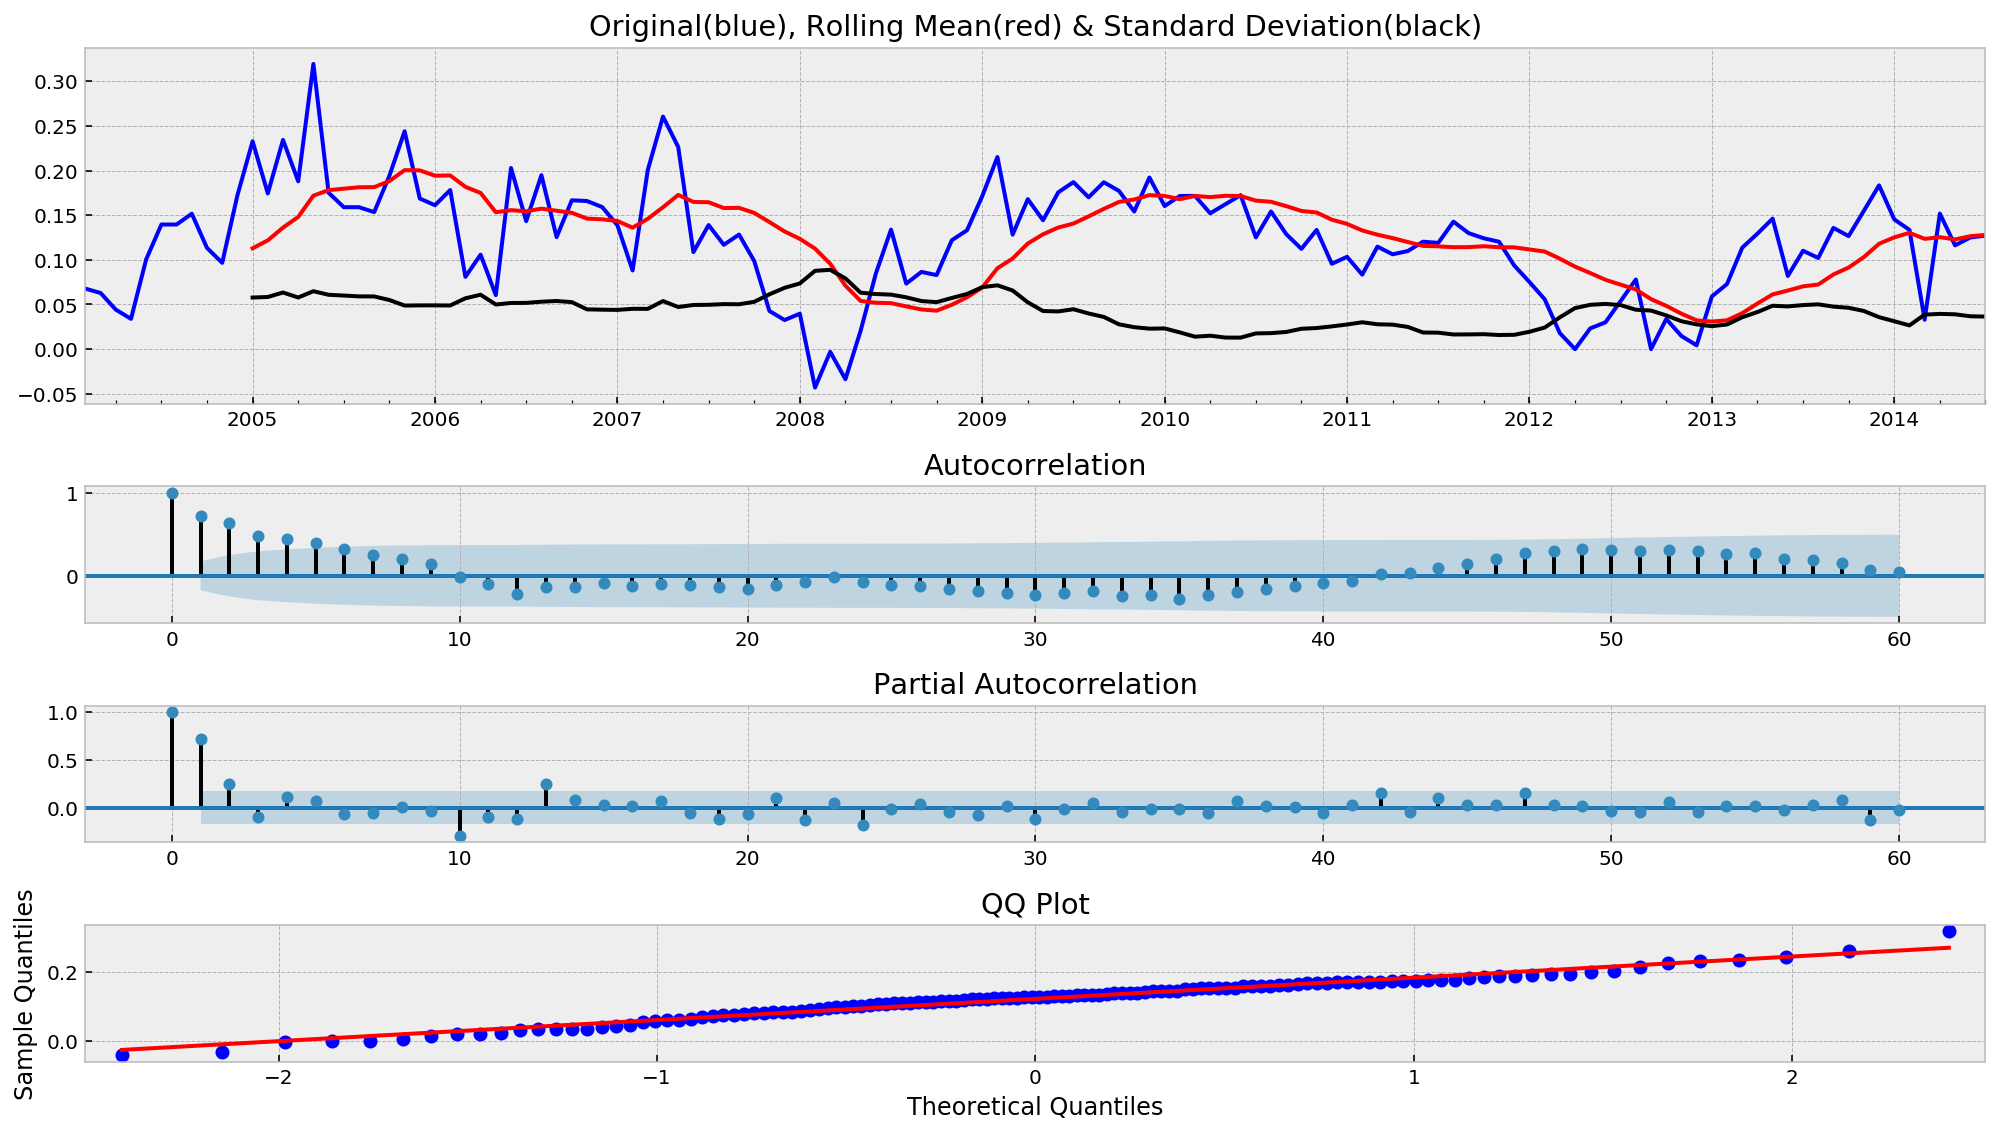

In [25]:
# log seasonal component 12 month 
train['log_seasonal_difference'] = train.num_tr_log - train.num_tr_log.shift(12)
test_stationarity(train.log_seasonal_difference.dropna(inplace=False))
tsplot(train.log_seasonal_difference[13:], lags = 60)

Удаление сезонной компоненты из логарифмированного ряда не дает лучший результат, 
чем простое удаление сезонной компоненты. Продолжаем эксперименты далее.

Results of Dickey-Fuller Test:
Test Statistic                -1.515064e+01
p-value                        6.805180e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.250000e+02
Critical Value (1%)           -3.483779e+00
Critical Value (5%)           -2.884954e+00
Critical Value (10%)          -2.579257e+00
dtype: float64


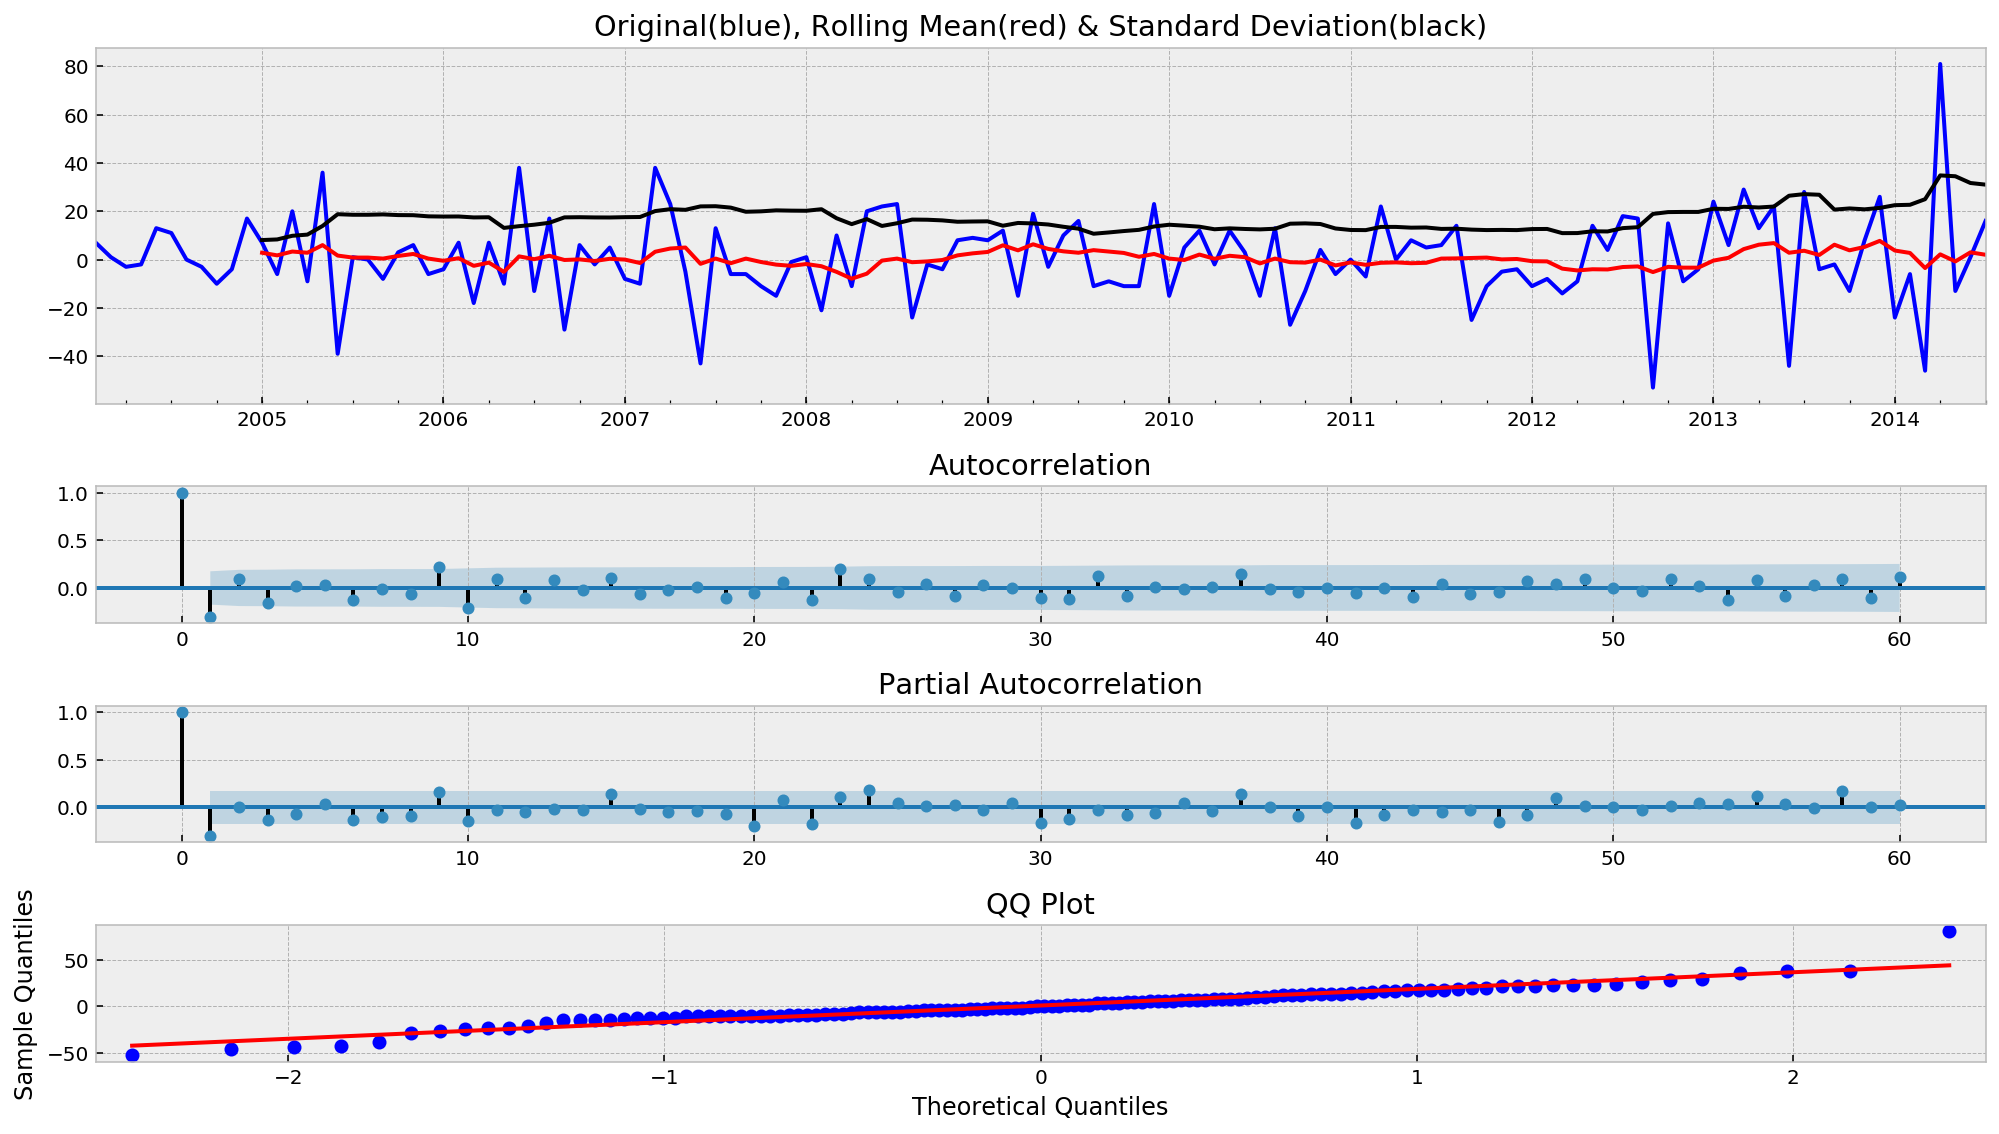

In [26]:
# Удаление сезонной компоненты из ряда с первыми разностями
train['seasonal_first_difference'] = train.first_difference - train.first_difference.shift(12)
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)
test_stationarity(train.seasonal_first_difference.dropna(inplace=False))
tsplot(train.seasonal_first_difference[13:], lags = 60)

Удаление сезонной компоненты из ряда первых разностей дает очень хороший результат. Тест ДФ с очень низким p-value. 
Корелляционные функции после первого лага затухли и колеблются в пределах дисперсии.
QQ plot линейный с единственным выбросом.

Results of Dickey-Fuller Test:
Test Statistic                  -4.386730
p-value                          0.000313
#Lags Used                      12.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


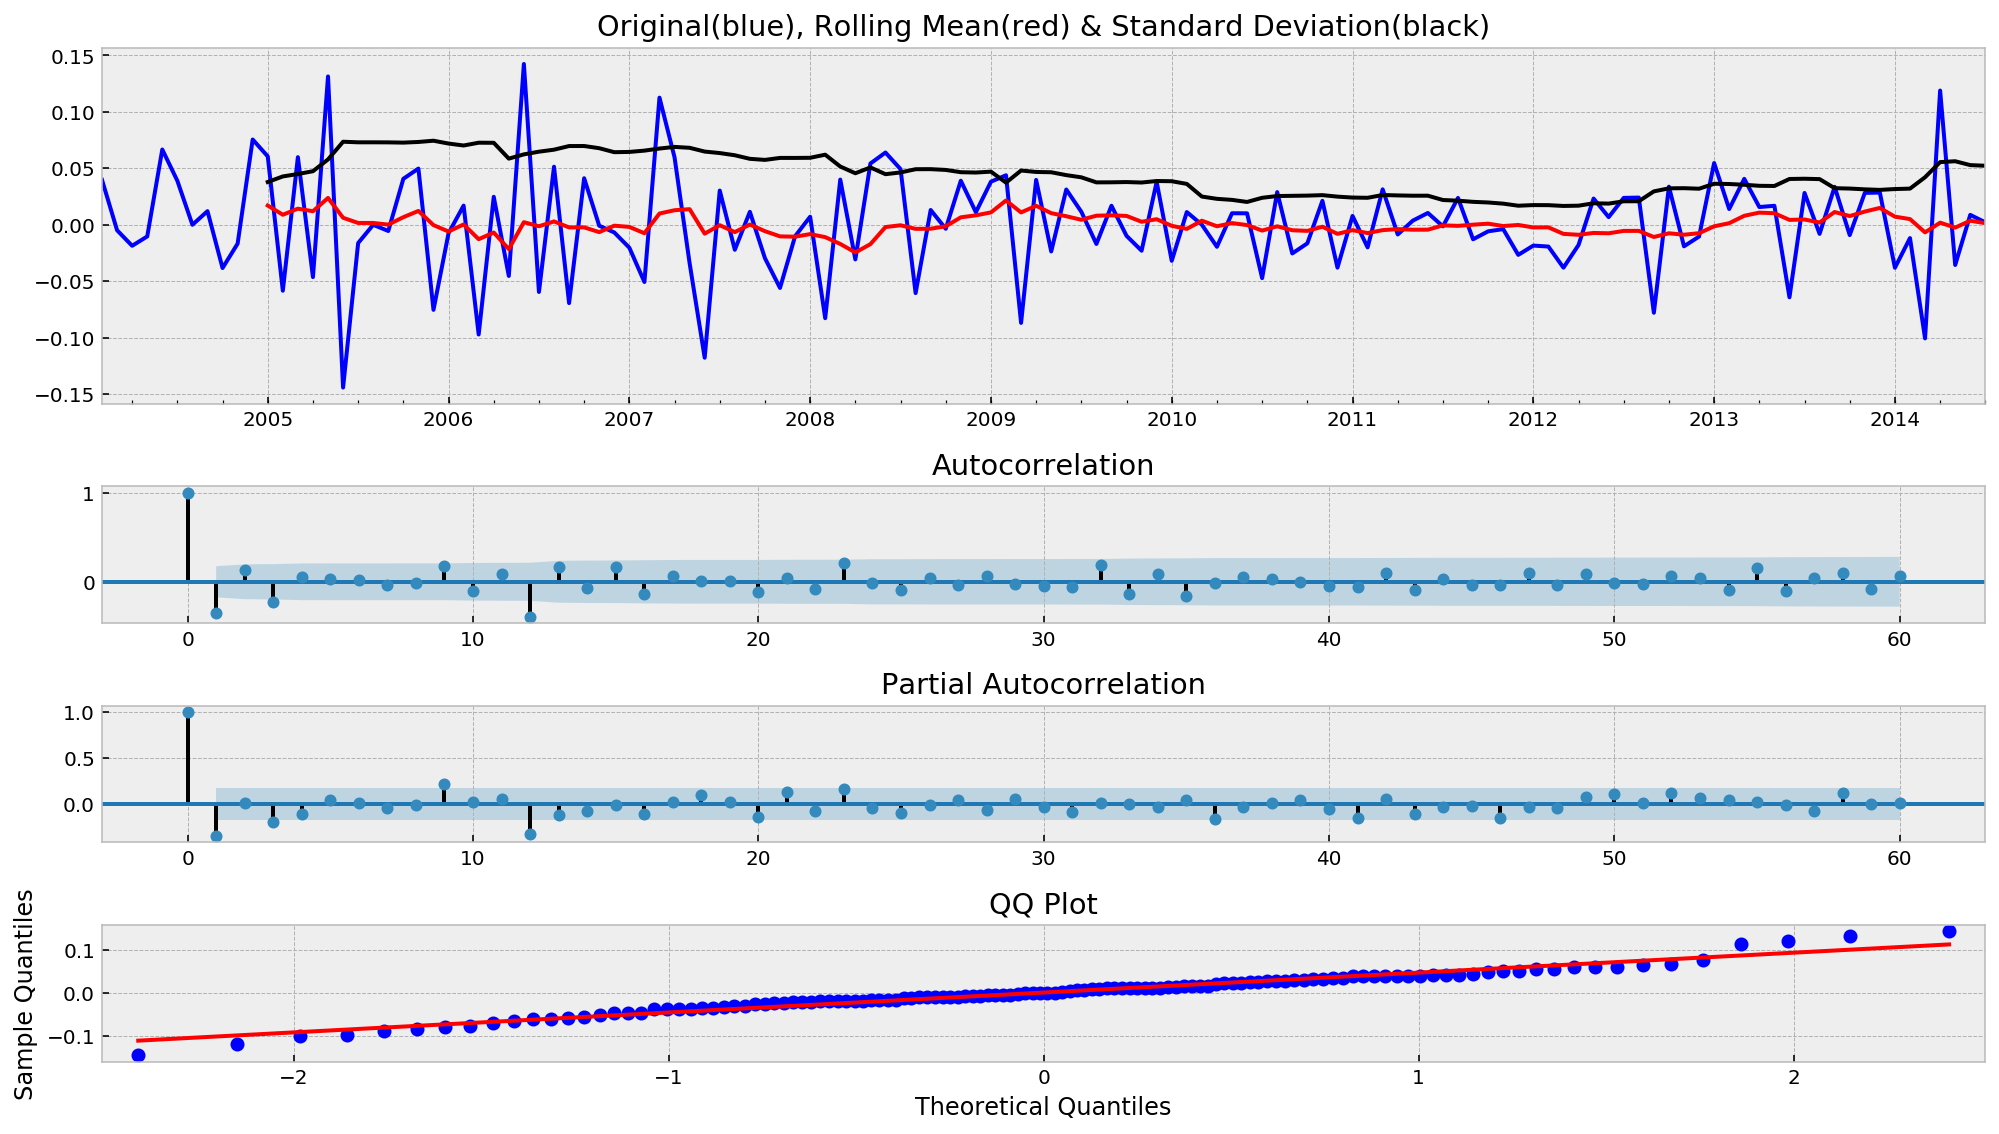

In [27]:
# Удаление сезонной компоненты из логарифмированного ряда первых разностей
train['log_seasonal_first_difference'] = train.log_first_difference - train.log_first_difference.shift(12)
test_stationarity(train.log_seasonal_first_difference.dropna(inplace=False))
tsplot(train.log_seasonal_first_difference[13:], lags = 60)

Удаление сезонной компоненты из логарифмированного ряда первых разностей привело к стационарному ряду, но 
дало не самый лучший результат по оценкам.

В результате экспериментов оказалось, что наилучший способ привести данный ряд к стационарному - удаление сезонной компоненты (12 месяцев) из ряда первых разностей

п. 5 Подберите модель, хорошо описывающую обучающую выборку, каждым способом:

* перебором коэффициентов и сортировкой по AIC;
* перебором коэффициентов и сортировкой по MAP E (mean absolute percentage error);
* с помощью подхода Бокса–Дженкинса к идентификации временных рядов (описан на слайде 22);


а) по AIC

In [54]:
from sklearn.metrics import *

In [55]:
# зададим сезонность вектором np.array([3,6,12,24])

In [61]:
%%time
best_mdl = sarima_best_order(train.num_tr, np.array([3,6,12,24]))

aic: 1209.12321 | order: (3, 1, 1) | order_s: (3, 0, 1, 3)
Wall time: 4min 48s


In [62]:
res_aic = best_mdl.fit()
df['f_aic'] = res_aic.predict(start = 139, end= 144, dynamic= True)

In [ ]:
# зафиксируем сезонность в 12 месяцев (которую наблюдали)

In [63]:
%%time
best_mdl_12 = sarima_best_order(train.num_tr, np.array([12]))

aic: 1358.80399 | order: (3, 1, 3) | order_s: (0, 0, 1, 12)
Wall time: 25.4 s


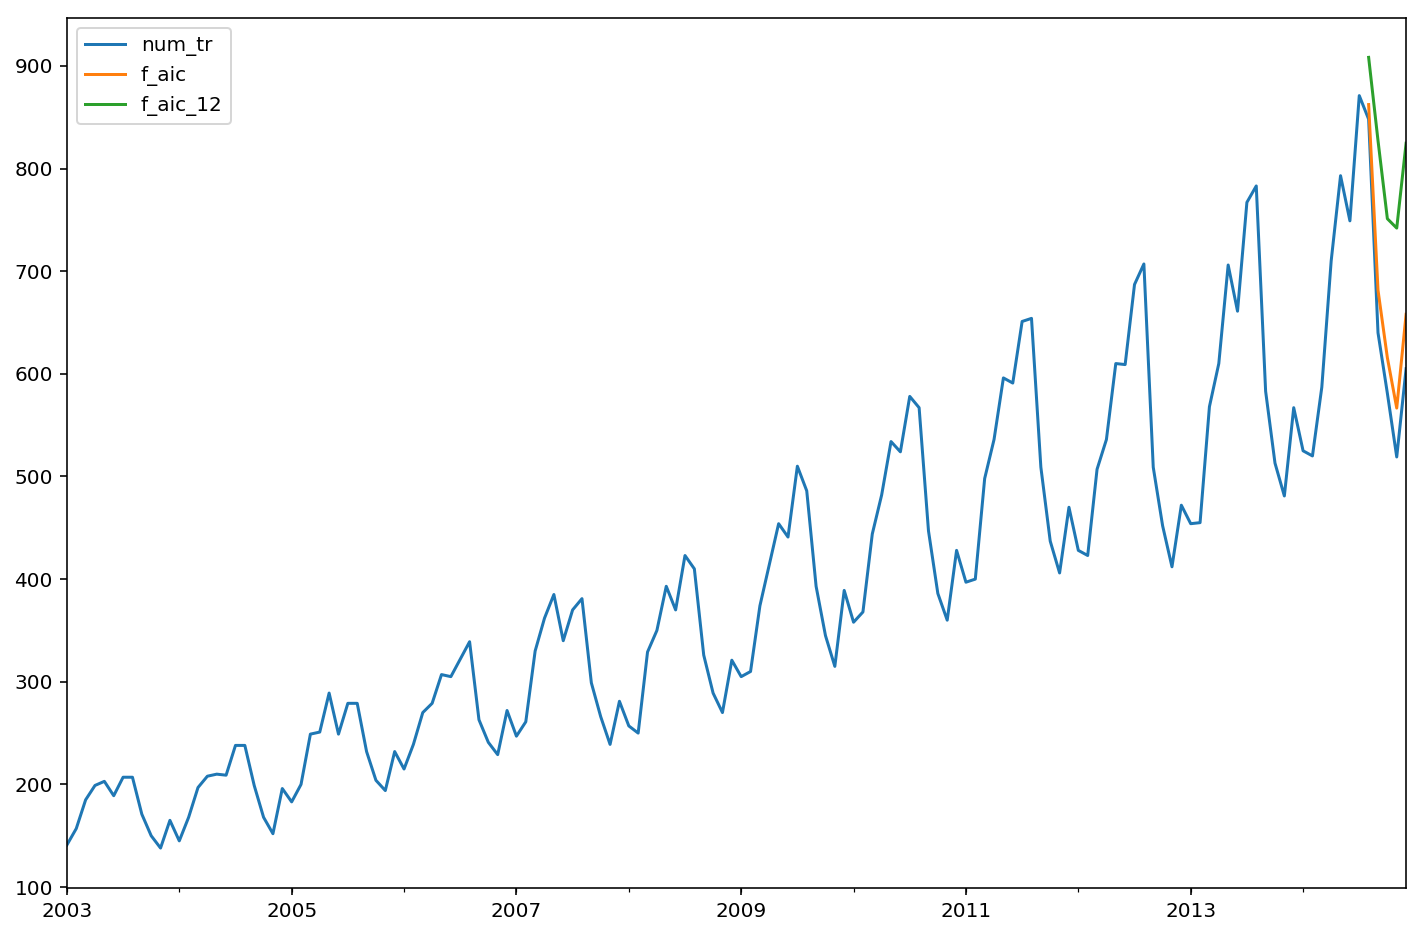

In [64]:
res_aic_12 = best_mdl_12.fit()
df['f_aic_12'] = res_aic_12.predict(start = 139, end= 144, dynamic= True)
df[['num_tr', 'f_aic', 'f_aic_12']].plot(figsize=(12, 8) )

Как видно на полученных графиках, то предсказание, где сезонность не зафиксирована, более точное.

In [52]:
# выведем результаты, см. столбцы f_aic, f_aic_12; цифры столбца f_aic ближе к test
df[df.f_aic.isnull() == False]

,date,num_tr,first_difference,seasonal_first_difference,f_aic,f_aic_12
2014-08-01,Aug-14,848,-23.0,-39.0,862.198033,851.065664
2014-09-01,Sep-14,640,-208.0,-8.0,682.240651,766.018290
2014-10-01,Oct-14,581,-59.0,11.0,617.883473,681.295334
2014-11-01,Nov-14,519,-62.0,-30.0,567.386815,653.970956
2014-12-01,Dec-14,605,86.0,0.0,659.448726,711.473334


б) по MAP E

In [101]:
%%time
best_mdl_m = sarima_best_order_mape(train.num_tr, np.array([3,6,12,24]))

mape: 0.10058 | order: (4, 1, 4) | order_s: (3, 0, 0, 3)
Wall time: 19min 2s


In [103]:
res_mape = best_mdl_m.fit()
df['f_mape'] = res_mape.predict(start = 139, end= 144, dynamic= True)

In [104]:
# попробуем вручную регулировать сезонность 12 месяцев
%%time
best_mdl_m_12 = sarima_best_order_mape(train.num_tr, np.array([12]))

mape: 0.16561 | order: (4, 1, 4) | order_s: (0, 0, 1, 12)
Wall time: 1min 34s


In [105]:
res_mape_12 = best_mdl_m_12.fit()
df['f_mape_12'] = res_mape_12.predict(start = 139, end= 144, dynamic= True)

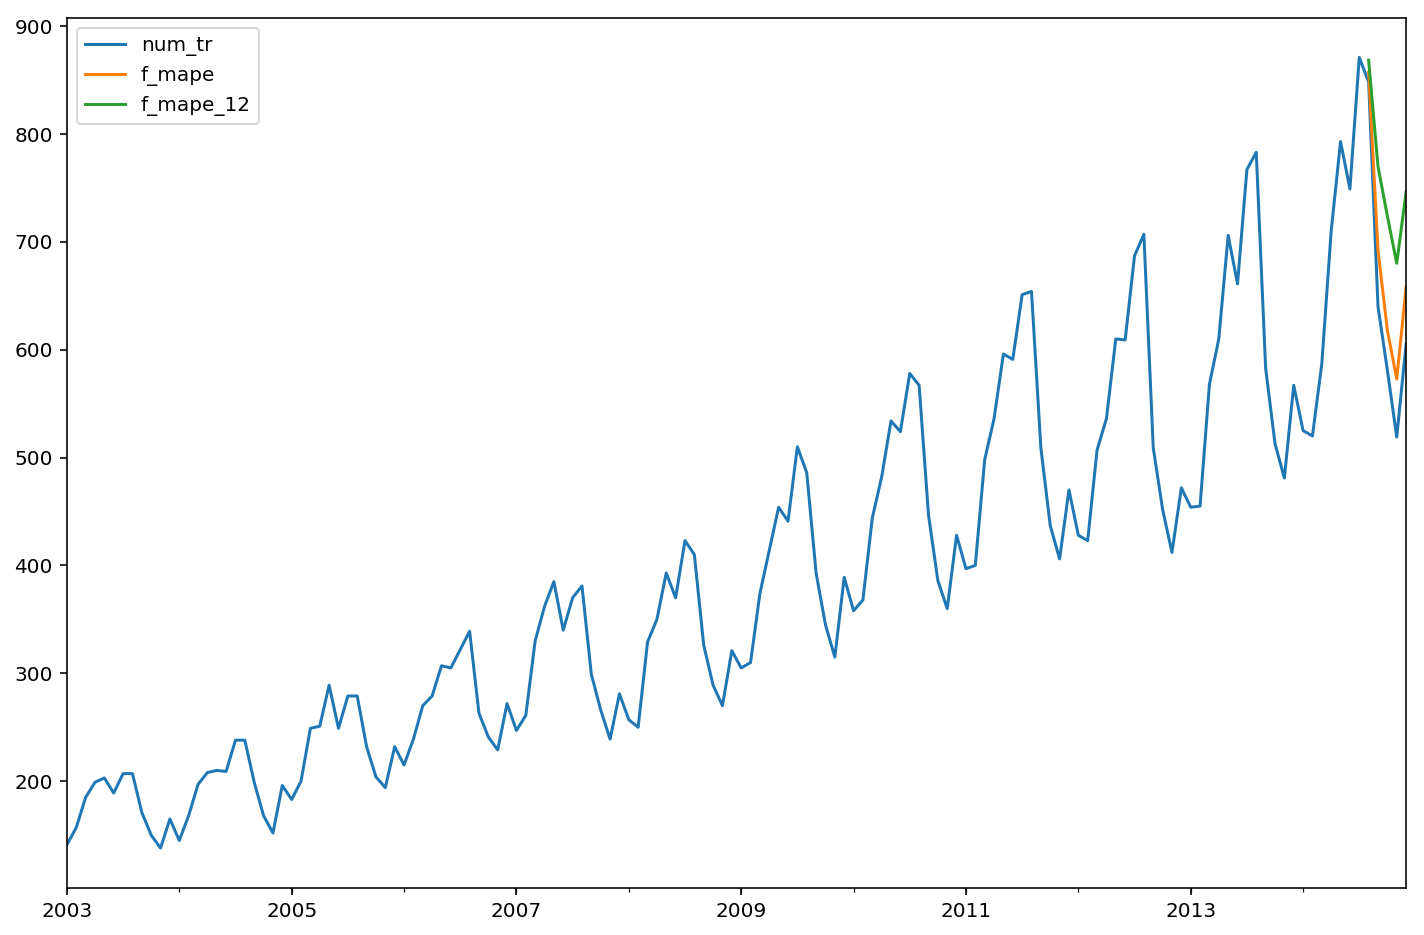

In [106]:
df[['num_tr', 'f_mape', 'f_mape_12']].plot(figsize=(12, 8) )

In [107]:
# выведем результаты, см. столбцы f_aic, f_aic_12; цифры столбца f_aic ближе к test
df[df.f_mape.isnull() == False]

,date,num_tr,first_difference,seasonal_first_difference,f_aic,f_aic_12,f_mape,f_mape_12,f_bj
2014-08-01,Aug-14,848,-23.0,-39.0,862.287306,908.260604,857.044865,868.328021,871.394075
2014-09-01,Sep-14,640,-208.0,-8.0,681.464815,827.171955,692.269421,769.809201,733.378878
2014-10-01,Oct-14,581,-59.0,11.0,615.641809,751.084227,617.955796,723.924119,631.052669
2014-11-01,Nov-14,519,-62.0,-30.0,566.610456,741.956381,572.799446,680.084546,580.640069
2014-12-01,Dec-14,605,86.0,0.0,658.008035,824.653153,657.746344,746.218295,640.479842


в) по Боксу-Дженкинсу

по графикам корреляции и автокорреляции первых разностей (логарифмированные и нелогарифмированные данные) визуально определяем, что есть компоненты p = 6, q = 6 (эти лаги больше доверительного интервала).
Используем модель (6,1,6) (p, d, q)

Для порядка ma и ar компонент нужно вернуться к графикам, acf и pacf, где удалось добиться стационарности, построенных для сезонной компоненты от первых разностей. Из них: d = 0 (не брали первую разность от сезонности), лаги больше ноля у pacf p = 1, у acf q = 1. Используем (1, 0, 1, 12) для сезонности.

In [119]:
best_mdl_bj = smt.SARIMAX(train.num_tr, trend='n', order=(6, 1, 6), seasonal_order=(1,0,1,12), 
                         enforce_invertibility = False, # иначе при заданных параметрах выпадает с ошибкой
                         enforce_stationarity = False) # иначе при заданных параметрах выпадает с ошибкой
res_bj = best_mdl_bj.fit()
df['f_bj'] = res_bj.predict(start = 139, end= 144, dynamic= True)

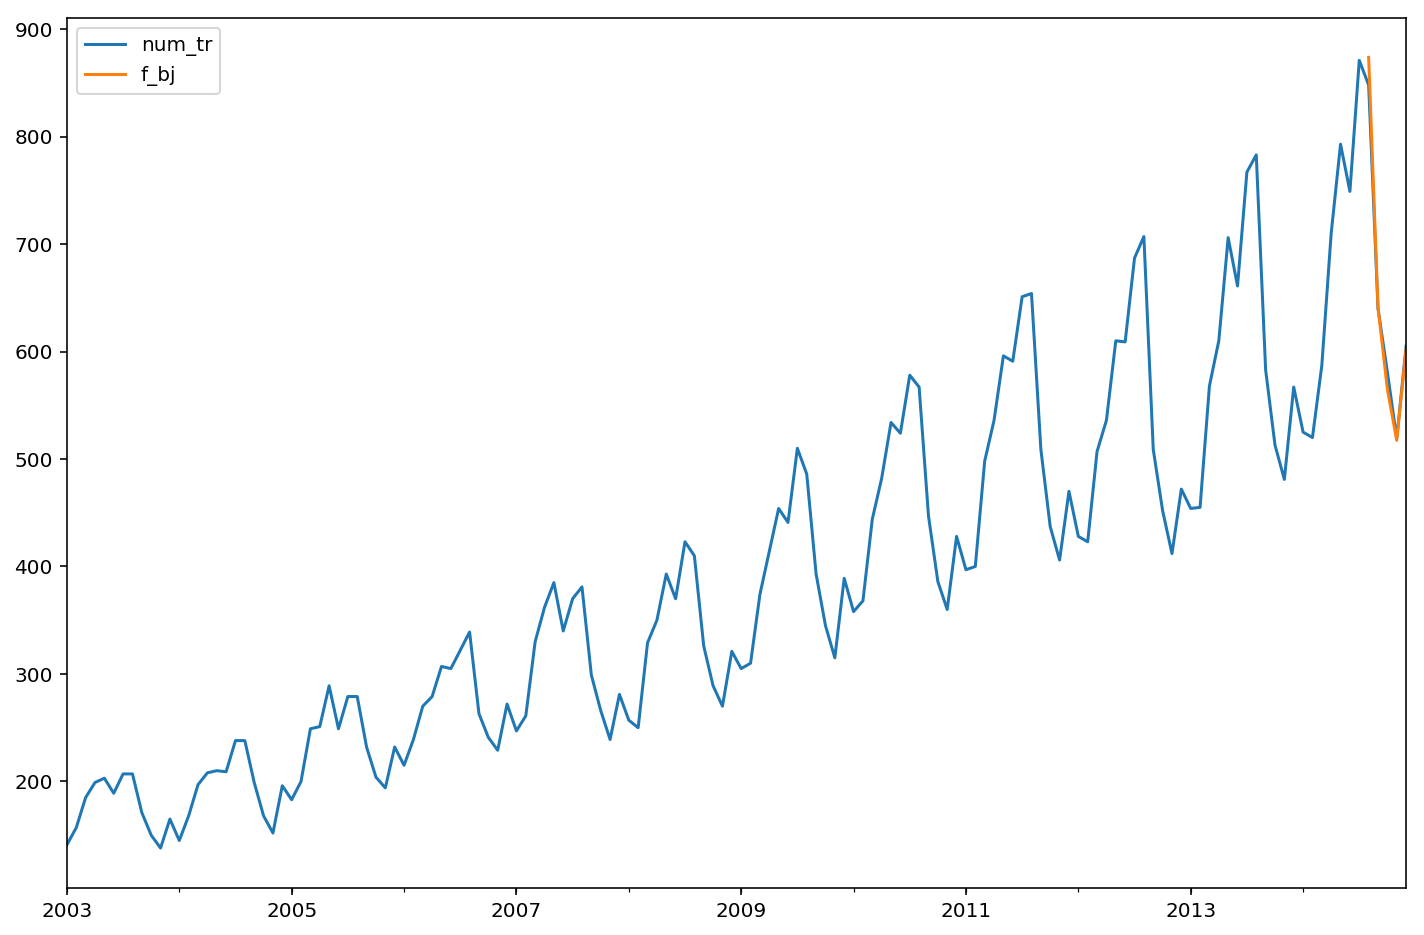

In [120]:
df[['num_tr', 'f_bj']].plot(figsize=(12, 8) )

In [121]:
test

,date,num_tr,first_difference,seasonal_first_difference,f_aic,f_aic_12
2014-08-01,Aug-14,848,-23.0,-39.0,862.198033,851.065664
2014-09-01,Sep-14,640,-208.0,-8.0,682.240651,766.018290
2014-10-01,Oct-14,581,-59.0,11.0,617.883473,681.295334
2014-11-01,Nov-14,519,-62.0,-30.0,567.386815,653.970956
2014-12-01,Dec-14,605,86.0,0.0,659.448726,711.473334


Оценим mape для полученных предсказаний


In [122]:
#переопределим test, чтбы удобнее было работать дальше
test = df[df.index >= '2014-08-01']

In [123]:
test

,date,num_tr,first_difference,seasonal_first_difference,f_aic,f_aic_12,f_mape,f_mape_12,f_bj
2014-08-01,Aug-14,848,-23.0,-39.0,862.287306,908.260604,857.044865,868.328021,873.732449
2014-09-01,Sep-14,640,-208.0,-8.0,681.464815,827.171955,692.269421,769.809201,641.127315
2014-10-01,Oct-14,581,-59.0,11.0,615.641809,751.084227,617.955796,723.924119,564.867559
2014-11-01,Nov-14,519,-62.0,-30.0,566.610456,741.956381,572.799446,680.084546,517.381433
2014-12-01,Dec-14,605,86.0,0.0,658.008035,824.653153,657.746344,746.218295,602.351212


In [132]:
# aic
mape_aic = mape_f(test.num_tr, test.f_aic)
print('подбор параметров по AIC mape={:.2f} для test'.format(mape_aic))

по AIC mape=7.64 для test


In [133]:
#mape
mape_mp = mape_f(test.num_tr, test.f_mape)
print('подбор параметров по MAPE mape={:.2f} для test'.format(mape_mp))

подбор параметров по MAPE mape=8.19 для test


In [135]:
#bj
mape_bj = mape_f(test.num_tr, test.f_bj)
print('подбор параметров по БД mape={:.2f} для test'.format(mape_bj))

подбор параметров по БД mape=1.89 для test


Наименьший mape дал ручной подбор параметров, модель p,d,q order=(6, 1, 6), seasonal_order = (1,0,1,12)

Стоить отметить, что в автоматическом режиме подбирались модели с параметром сезонности 3 месяца. Для интереса 
взглянем на графики разложения на компоненты с сезонностью 3 месяца.

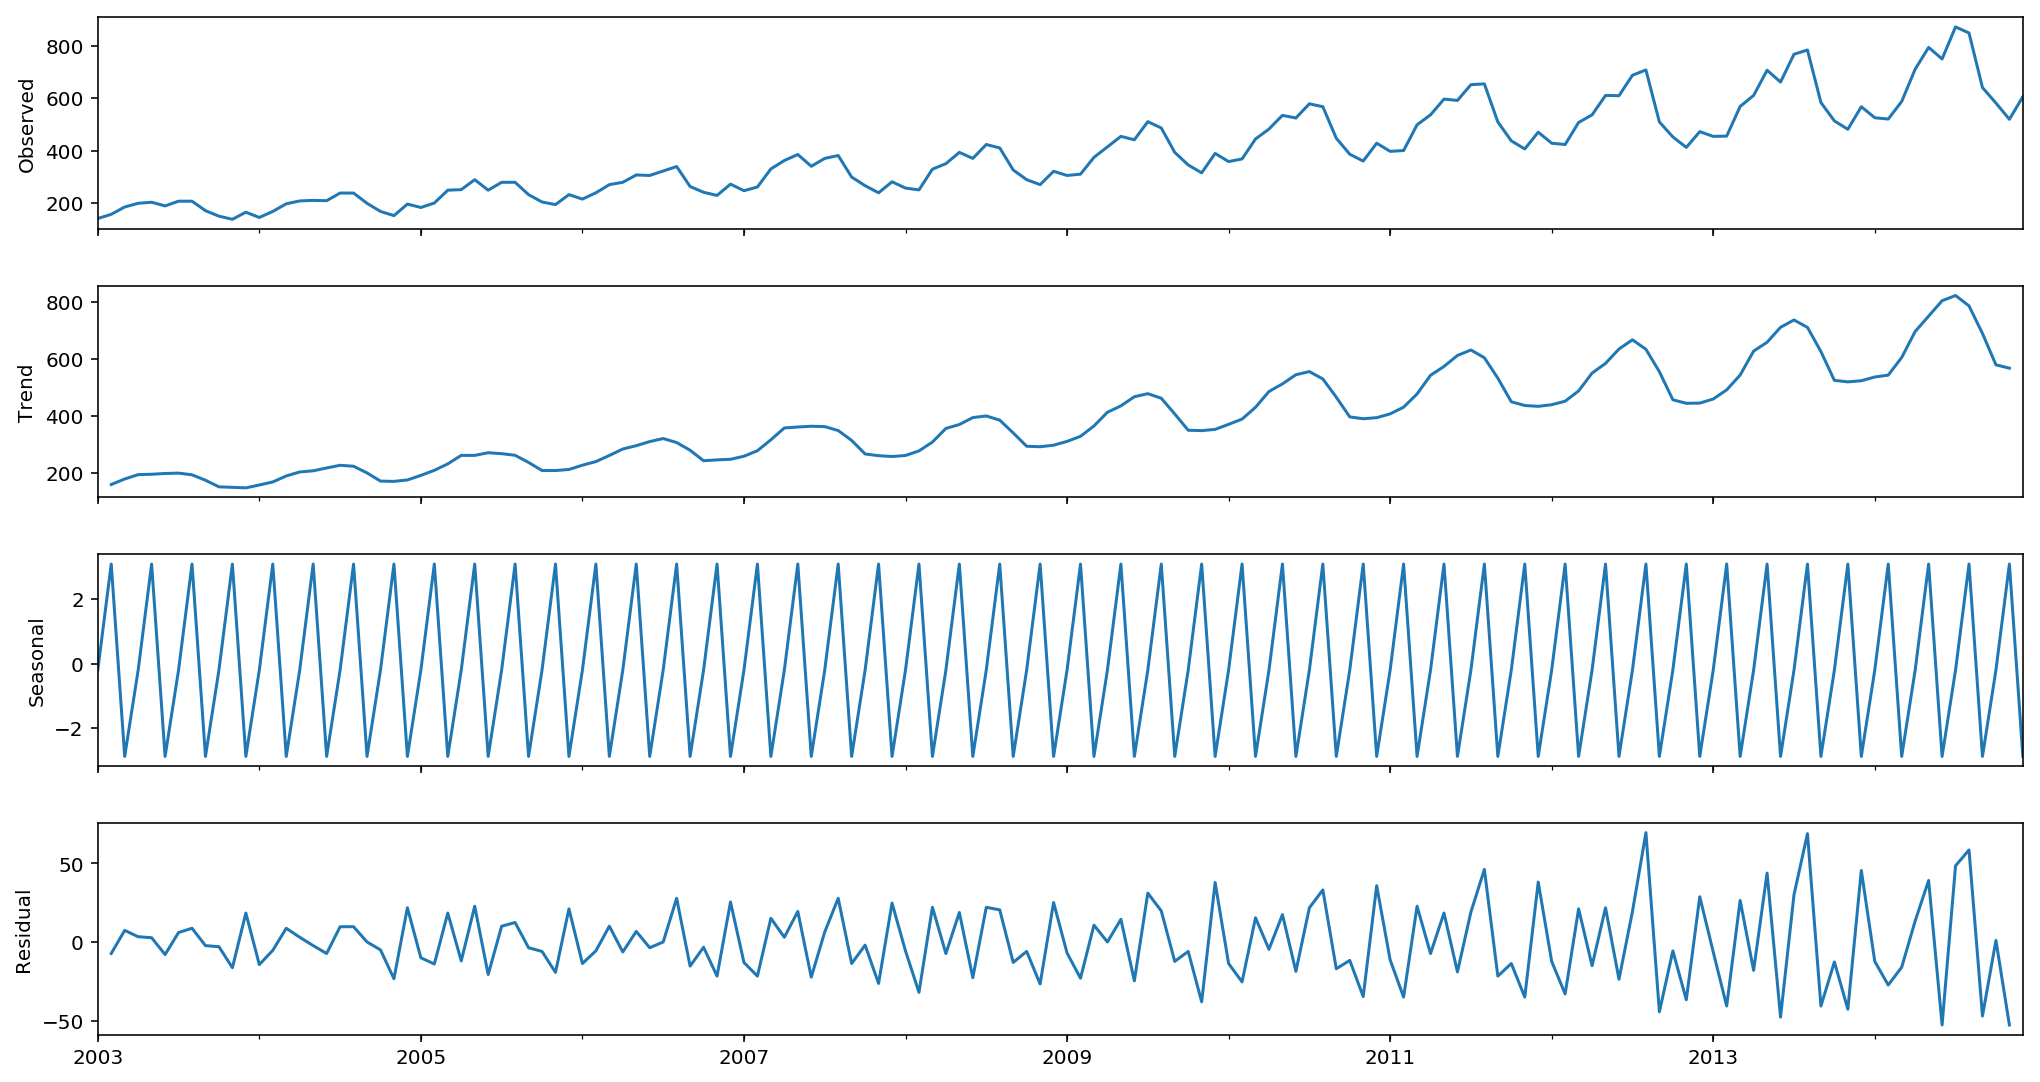

In [136]:
seasonal_decompose_plot(df.num_tr,  freq=3)

Что интересно, эта сезонность не наблюдалась на графиках pacf, но именно такая сезонность дает идеальные 
графики тренда, сезонности, и остатков, которые точно представляют собой белый шум.